<a id = 'toc'></a>
# Table of Contents

- ### [Preprocessing-Light](#preprocessing_light)
- ### [Preprocessing-Pandas](#preprocessing_pandas)
- ### [Word vectorization](#word_vectorization)
- ### [Example 1](#example_1)
- ### [Gensim](#gensim)
- ### [Text Classification](#text_classification)
- ### [Example 2: ChatBotPractice](#example_2)

<a id = 'preprocessing_light'></a>
# Preprocessing-Light

---
## Decoding
converting a sequence of bytes into a sequence of characters.

- **Unpacking** \
*.plain/.zip/.gz/...*
- **Encoding** \
*ASCII/utf-8/Windows-1251/...*
- **Format** \
*csv/xml/json/doc/...*

---

## Split into tokens
splitting a sequence of characters into parts (tokens), possibly excluding some characters from consideration.
Naive approach: split the string with spaces and throw out punctuation marks.

**Problems:**  
* example@example.com, 127.0.0.1
* С++, C#
* York University vs New York University
* Language dependency (“Lebensversicherungsgesellschaftsangestellter”, “l’amour”)

Alternative: n-grams

---

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Leo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from nltk.tokenize import RegexpTokenizer

sequence = 'The quick brown fox jumps, and jumps over the lazy dog'

tokenizer = RegexpTokenizer('\w+|[^\w\s]+')
for token in tokenizer.tokenize(sequence):
    print(token)

The
quick
brown
fox
jumps
,
and
jumps
over
the
lazy
dog


---
## Stop words
the most frequent words in the language that do not contain any information about the content of the text

**Problem**: To be or not to be.

---

In [3]:
from nltk.corpus import stopwords

print(' '.join(stopwords.words('english')[1:20]))

me my myself we our ours ourselves you you're you've you'll you'd your yours yourself yourselves he him his


---
## Normalization
Bringing tokens to a single form in order to get rid of superficial differences in spelling

**Approaches:**
* formulate a set of rules by which the token is transformed \
New-Yorker → new-yorker → newyorker → newyork
* explicity store connections betweens tokens (WordNet - Princeton) \
car → auto, Window 6 → window
машина → автомобиль, Windows 6→ window

---

In [4]:
word = 'New-Yorker'

word_1 = word.lower()

import re
word_2 = re.sub(r'\W', '', word_1, flags = re.U)

word_3 = re.sub(r'er', '', word_2, flags = re.U)

print(f'{word} → {word_1} → {word_2} → {word_3}')

New-Yorker → new-yorker → newyorker → newyork


---
## Stemming and Lemmatization
**Stemming** is a process that stems or removes last few characters from a word, often leading to incorrect meanings and spelling.
**Lemmatization** considers the conext and converts the word to its meaningful base form, which is called *Lemma*.

**Example:**
* Steeming
Caring → Car
* Lemmatization
Caring → Care

---

## Stemming

In [5]:
from nltk.stem.snowball import PorterStemmer
from nltk.stem.snowball import EnglishStemmer

p_stemmer = PorterStemmer()
print(f'[Porter Stemmer]: {p_stemmer.stem("New-Yorker")}')
print(f'[Porter Stemmer]: {p_stemmer.stem("Tokenization")}')

eng_stemmer = EnglishStemmer()
print(f'[English Stemmer]: {eng_stemmer.stem("Perfection")}')
print(f'[English Stemmer]: {eng_stemmer.stem("Difference")}')

[Porter Stemmer]: new-york
[Porter Stemmer]: token
[English Stemmer]: perfect
[English Stemmer]: differ


## Lemmatization

In [6]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()
print(f'[pymorphy2]: {morph.parse("New-Yorker")[0].normal_form}')
print(f'[pymorphy2]: {morph.parse("Tokenization")[0].normal_form}')
print(f'[pymorphy2]: {morph.parse("Perfection")[0].normal_form}')
print(f'[pymorphy2]: {morph.parse("Difference")[0].normal_form}')

[pymorphy2]: new-yorker
[pymorphy2]: tokenization
[pymorphy2]: perfection
[pymorphy2]: difference


---

## Heap's Law (Herdan's law)
An empirical regularity in linguistics that describes the distribution of the number of unique words in a document (or set of documents) as a function of it's length.


$ M = kT^{\beta}$
- $M$ - dictionary size
- $T$ - word count
- $30 \leq k \leq 100, b \approx 0.5$

---

[UP](#toc)

<a id = 'preprocessing_pandas'></a>
# Preprocessing-Pandas

#### Using methods

In [8]:
import pandas as pd

sequences_list = pd.Series(['Our mother washed - The Dishes', 'The countdown, Is over'], dtype = "string")
print(f'[BEFORE]: {sequences_list[0]}')

sequences_list = sequences_list.str.lower()
sequences_list = sequences_list.str.strip()
#sequences_list = sequences_list.str.split(' ', expand = True)
sequences_list = sequences_list.str.split(' ')
print(f'[AFTER]: {sequences_list[0]}')

[BEFORE]: Our mother washed - The Dishes
[AFTER]: ['our', 'mother', 'washed', '-', 'the', 'dishes']


#### Using functions

In [9]:
import string
import pymorphy2

morpher = pymorphy2.MorphAnalyzer()
sw = ['dishes']

def preprocess_txt(line):
    exclude = set(string.punctuation)
    spls = ''.join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw and i != '']
    return spls
    
sequences_list = pd.Series(['Our mother washed - The Dishes', 'The countdown, Is over'], dtype = "string")
print(f'[BEFORE]: {sequences_list[0]}')
sequences_list = sequences_list.apply(lambda x: preprocess_txt(x))
print(f'[AFTER]: {sequences_list[0]}')

[BEFORE]: Our mother washed - The Dishes
[AFTER]: ['our', 'mother', 'washed', 'the']


[UP](#toc)

<a id = 'word_vectorization'></a>
# Word vectorization

### Bag-of-Words

In [13]:
documents = ["I like this movie, it's funny.", "I hate this movie."
             , "This was awesome! I like it.", "Nice one. I love it."]

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

count_vectorizer = CountVectorizer()
bag_of_words = count_vectorizer.fit_transform(documents)

count_vectorizer.fit_transform(documents)

feature_names = count_vectorizer.get_feature_names_out()
pd.DataFrame(bag_of_words.toarray(), columns = feature_names)

,awesome,funny,hate,it,like,love,movie,nice,one,this,was
0,0,1,0,1,1,0,1,0,0,1,0
1,0,0,1,0,0,0,1,0,0,1,0
2,1,0,0,1,1,0,0,0,0,1,1
3,0,0,0,1,0,1,0,1,1,0,0


### N-gramm

In [14]:
from nltk.util import ngrams

text = "I like this movie, it's funny. I hate this movie. This was awesome! I like it. Nice one. I love it."

tokenized = text.split()
bigrams = ngrams(tokenized, 2)
for i in bigrams:
    print(i)

('I', 'like')
('like', 'this')
('this', 'movie,')
('movie,', "it's")
("it's", 'funny.')
('funny.', 'I')
('I', 'hate')
('hate', 'this')
('this', 'movie.')
('movie.', 'This')
('This', 'was')
('was', 'awesome!')
('awesome!', 'I')
('I', 'like')
('like', 'it.')
('it.', 'Nice')
('Nice', 'one.')
('one.', 'I')
('I', 'love')
('love', 'it.')


### TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

document = ["I like this movie, it's funny.", "I hate this movie."
            , "This was awesome! I like it.", "Nice one. I love it."]
tfidf_vectorizer = TfidfVectorizer()
values = tfidf_vectorizer.fit_transform(document)

feature_name = tfidf_vectorizer.get_feature_names_out()
pd.DataFrame(values.toarray(), columns = feature_names)

,awesome,funny,hate,it,like,love,movie,nice,one,this,was
0,0.000000,0.571848,0.000000,0.365003,0.450852,0.000000,0.450852,0.000000,0.000000,0.365003,0.000000
1,0.000000,0.000000,0.702035,0.000000,0.000000,0.000000,0.553492,0.000000,0.000000,0.448100,0.000000
2,0.539445,0.000000,0.000000,0.344321,0.425305,0.000000,0.000000,0.000000,0.000000,0.344321,0.539445
3,0.000000,0.000000,0.000000,0.345783,0.000000,0.541736,0.000000,0.541736,0.541736,0.000000,0.000000


### Hashing

In [16]:
from sklearn.feature_extraction.text import HashingVectorizer

document = ["I like this movie, it's funny.", "I hate this movie."
            , "This was awesome! I like it.", "Nice one. I love it."]

vectorizer = HashingVectorizer()
values = vectorizer.fit_transform(document)

pd.DataFrame(values.toarray())

,0,1,2,3,4,5,6,7,8,9,...,1048566,1048567,1048568,1048569,1048570,1048571,1048572,1048573,1048574,1048575
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[UP](#toc)

<a id = 'example_1'></a>
# Example 1

In [2]:
import numpy as np
import matplotlib.pyplot
%matplotlib inline

import datasets
import tokenizers
import wandb
from tqdm.auto import tqdm

import torch 
import torch.nn as nn
import torch.nn.functional as F

In [3]:
dataset = datasets.load_dataset('imdb'
                                , split = 'train'
                                , download_mode = 'force_redownload')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
df = dataset
df = datasets.load_dataset('imdb')

In [5]:
df

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

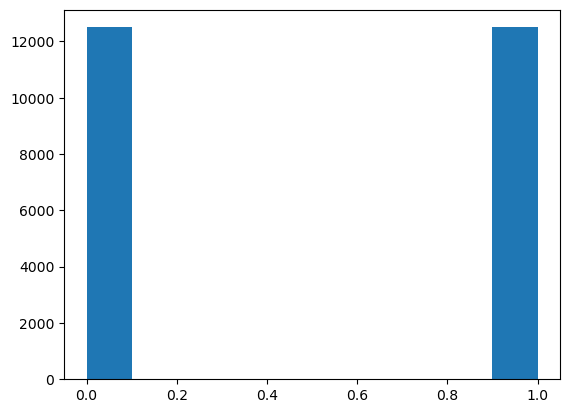

In [6]:
import matplotlib.pyplot as plt

train_labels = [i['label'] for i in df['train']]
plt.hist(train_labels)
plt.show()

### Classification using Linear Models

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vectorizer = TfidfVectorizer(max_features = 25000)
values = vectorizer.fit_transform(df['train']['text'])

feature_names = vectorizer.get_feature_names_out()
pd.DataFrame(values.toarray(), columns = feature_names)

,00,000,007,00s,01,02,03,04,05,06,...,zooming,zooms,zorak,zorro,zp,zu,zucker,zulu,zuniga,zwick
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
vectorizer = TfidfVectorizer(max_features = 25000)
vectorizer = vectorizer.fit(df['train']['text'])

x_train = vectorizer.transform(df['train']['text'])
y_train = np.array(df['train']['label'])

x_test = vectorizer.transform(df['test']['text'])
y_test = np.array(df['test']['label'])

x_train, y_train

(<25000x25000 sparse matrix of type '<class 'numpy.float64'>'
 	with 3355130 stored elements in Compressed Sparse Row format>,
 array([0, 0, 0, ..., 1, 1, 1]))

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error

model = LogisticRegression()
model = model.fit(x_train, y_train)

log_pred = model.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, log_pred))
acc = accuracy_score(y_test, log_pred)

print(f'[RMSE]: {rmse:.2f}, [ACC]: {acc:.2f}')

[RMSE]: 0.34, [ACC]: 0.88


#### Testing model prediction

In [10]:
positive_comment = 'This movie is awesome!'
vec = vectorizer.transform([positive_comment])
positive_pred = model.predict(vec)

negative_comment = 'This movie is awful!'
vec = vectorizer.transform([negative_comment])
negative_pred = model.predict(vec)

print(f'[PositiveComment]: {positive_pred[0]}, \
[NegativeComment]: {negative_pred[0]}')

[PositiveComment]: 1, [NegativeComment]: 0


[UP](#toc)

<a id = 'gensim'></a>
# Gensim

In [4]:
import gensim.downloader as api

word_vectors = api.load('glove-wiki-gigaword-100')

result = word_vectors.most_similar(positive = ['woman', 'king'], negative = ['man'])
print(word_vectors.doesnt_match('breakfast dinner cereal lunch'.split()))

similarity = word_vectors.similarity('woman', 'man')
print(f'{similarity:.2f}')

<a id = 'text_classification'></a>
# Text Classification

- Naive Bayes
- SVM
- LogisticRegression
- RandomForestClassifier
- XGBoostClassifier

In [87]:
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
#from sklearn import naive_bayes, linear_model, ensemble, svm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from tqdm import tqdm_notebook
%pylab inline

from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
from string import punctuation

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [88]:
df = pd.read_excel('Upload/14.7.xls')

In [89]:
df.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20659 entries, 0 to 20658
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Rating   20659 non-null  int64 
 1   Content  20656 non-null  object
 2   Date     20659 non-null  object
dtypes: int64(1), object(2)
memory usage: 484.3+ KB


In [91]:
exclude = set(punctuation)
sw = set(get_stop_words('ru'))
morpher = MorphAnalyzer()

In [92]:
df_sample = df.iloc[:5000]

In [93]:
def preprocess_text(line):
    splt = str(line)
    splt = ''.join(i for i in splt if i not in exclude)
    splt = splt.lower()
    splt = re.sub('не\s', 'не', splt)
    splt = [morpher.parse(word)[0].normal_form for word in splt.split() if word not in exclude]
    return ' '.join(splt)

#df_sample['Content'].apply(lambda x: preprocess_text(x))

In [94]:
df_sample['text'] = df_sample['Content'].apply(preprocess_text)
df_sample_rating = df_sample[df_sample['Rating'] != 3]
df_sample_rating['target'] = df_sample_rating['Rating'] > 3

C:\Users\Leo\AppData\Local\Temp\ipykernel_15996\725875120.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['text'] = df_sample['Content'].apply(preprocess_text)
C:\Users\Leo\AppData\Local\Temp\ipykernel_15996\725875120.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample_rating['target'] = df_sample_rating['Rating'] > 3


In [95]:
x_train, x_test, train_y, test_y = train_test_split(df_sample_rating['text']
                                                                    , df_sample_rating['target'])

encoder = LabelEncoder()
y_train = encoder.fit_transform(train_y)
y_test = encoder.fit_transform(test_y)

In [96]:
x_train.shape, x_test.shape

((3585,), (1195,))

In [115]:
count_vectorizer = CountVectorizer().fit(x_train.values)
x_train_count = count_vectorizer.transform(x_train)
x_test_count = count_vectorizer.transform(x_test)

tfidf_vectorizer = TfidfVectorizer().fit(x_train.values)
x_train_tfidf = tfidf_vectorizer.transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

tfidf_vectorizer_ngram = TfidfVectorizer(ngram_range = (1, 3)).fit(x_train.values)
x_train_tfidf_ngram = tfidf_vectorizer_ngram.transform(x_train)
x_test_tfidf_ngram = tfidf_vectorizer_ngram.transform(x_test)

In [117]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, is_neural_net = False):
    classifier.fit(feature_vector_train, label)
    predictions = classifier.predict(feature_vector_test)
    
    if is_neural_net:
        predictions = predictions.argmax(axis = -1)
        
    return accuracy_score(predictions, y_test)

## Naive Bayes

In [119]:
acc_nb_count = train_model(naive_bayes.MultinomialNB(), x_train_count, y_train, x_test_count)
acc_nb_tfidf = train_model(naive_bayes.MultinomialNB(), x_train_tfidf, y_train, x_test_tfidf)
acc_nb_tfidf_ngram = train_model(naive_bayes.MultinomialNB(), x_train_tfidf_ngram, y_train, x_test_tfidf_ngram)

print(f'[Count]: {acc_nb_count:.2f}, [TF-IDF]: {acc_nb_tfidf:.2f}, [TF-IDF N-Gram]: {acc_nb_tfidf_ngram:.2f}')

[Count]: 0.93, [TF-IDF]: 0.89, [TF-IDF N-Gram]: 0.87


## Linear Classifier - Logistic Regression

In [121]:
acclrcount = train_model(LogisticRegression(), x_train_count, y_train, x_test_count)
acclrtfidf = train_model(LogisticRegression(), x_train_tfidf, y_train, x_test_tfidf)
acclrtfidf_ngram = train_model(LogisticRegression(), x_train_tfidf_ngram, y_train, x_test_tfidf_ngram)

print(f'[Count]: {acclrcount:.2f}, [TF-IDF]: {acclrtfidf:.2f}, [TF-IDF N-Gram]: {acclrtfidf_ngram:.2f}')

[Count]: 0.91, [TF-IDF]: 0.90, [TF-IDF N-Gram]: 0.90


## SVM

In [122]:
acc_svm_count = train_model(svm.SVC(), x_train_count, y_train, x_test_count)
acc_svm_tfidf = train_model(svm.SVC(), x_train_tfidf, y_train, x_test_tfidf)
acc_svm_tfidf_ngram = train_model(svm.SVC(), x_train_tfidf_ngram, y_train, x_test_tfidf_ngram)

print(f'[Count]: {acc_svm_count:.2f}, [TF-IDF]: {acc_svm_tfidf:.2f}, [TF-IDF N-Gram]: {acc_svm_tfidf_ngram:.2f}')

[Count]: 0.91, [TF-IDF]: 0.91, [TF-IDF N-Gram]: 0.90


## Random Forest

In [124]:
clf = ensemble.RandomForestClassifier(n_estimators = 10000).fit(x_train_count, y_train)

In [125]:
acc_scores = []

for i in tqdm_notebook([10, 30, 60, 100, 1000, 2000]):
    clf =  ensemble.RandomForestClassifier(n_estimators = i).fit(x_train_count, y_train)
    acc_scores.append(accuracy_score(clf.predict(x_test_count), y_test))
    
acc_rfc_count = np.mean(acc_scores)

C:\Users\Leo\AppData\Local\Temp\ipykernel_12192\4151042975.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook([10, 30, 60, 100, 1000, 2000]):


  0%|          | 0/6 [00:00<?, ?it/s]

In [126]:
acc_rfc_tfidf = train_model(ensemble.RandomForestClassifier(), x_train_tfidf, y_train, x_test_tfidf)
acc_rfc_tfidf_ngram = train_model(ensemble.RandomForestClassifier(), x_train_tfidf_ngram, y_train, x_test_tfidf_ngram)

print(f'[Count]: {acc_rfc_count:.2f}, [TF-IDF]: {acc_rfc_tfidf:.2f}, [TF-IDF N-Gram]: {acc_rfc_tfidf_ngram:.2f}')

[Count]: 0.90, [TF-IDF]: 0.90, [TF-IDF N-Gram]: 0.90


## Boosting Model

In [128]:
acc_xgb_count = train_model(XGBClassifier(), x_train_count, y_train, x_test_count)
acc_xgb_tfidf = train_model(XGBClassifier(), x_train_tfidf, y_train, x_test_tfidf)
acc_xgb_tfidf_ngram = train_model(XGBClassifier(), x_train_tfidf_ngram, y_train, x_test_tfidf_ngram)

print(f'[Count]: {acc_xgb_count:.2f}, [TF-IDF]: {acc_xgb_tfidf:.2f}, [TF-IDF N-Gram]: {acc_xgb_tfidf_ngram:.2f}')

[Count]: 0.91, [TF-IDF]: 0.90, [TF-IDF N-Gram]: 0.90


<a id = 'example_2'></a>
# Example 2: ChatBotPractice

In [12]:
import string
import os 
import annoy
import codecs

from stop_words import get_stop_words
from gensim.models import Word2Vec
from pymorphy2 import MorphAnalyzer

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [48]:
start = 0
end = 1000

question = None
written = False

with codecs.open('Upload/prepared_answers.txt','w', 'utf-8') as fout:
    with codecs.open('Upload/14.8.txt', 'r', 'utf-8') as fin:
        for line in tqdm(fin):
            if line.startswith('---'):
                written = False
                continue
            if not written and question is not None:
                fout.write(question.replace('\t', ' ').strip() + '\t' + line.replace('\t', ' '))
                written = True
                question = None
                continue
            if not written:
                question = line.strip()
                continue                
            start += 1
            if start > end:
                break

0it [00:00, ?it/s]

### Count Vectorizer, Hashing Vectorizer, TF-IDF Vectorizer

In [26]:
# sentences_vec = pd.Series([' '.join(i) for i in [k for k in sentences if len(k) > 2]])

# from sklearn.feature_extraction.text import CountVectorizer

# count_vectorizer = CountVectorizer()
# x_train = count_vectorizer.fit_transform(sentences_vec)
# feature_names = count_vectorizer.get_feature_names_out()
# df_count_vectorizer = pd.DataFrame(x_train.toarray(), columns = feature_names)

# from sklearn.feature_extraction.text import HashingVectorizer

# hashing_vectorizer = HashingVectorizer()
# x_train = hashing_vectorizer.fit_transform(sentences_vec)
# df_hashing_vectorizer = pd.DataFrame(x_train.toarray())

# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vectorizer = TfidfVectorizer()
# x_train = tfidf_vectorizer.fit_transform(sentences_vec)
# feature_names = tfidf_vectorizer.get_feature_names_out()
# df_tfidf_vectorizer = pd.DataFrame(x_train.toarray(), columns = feature_names)

# print(f'[COUNT]: {df_count_vectorizer.shape}')
# print(f'[HASHING]: {df_hashing_vectorizer.shape}')
# print(f'[TF-IDF]: {df_tfidf_vectorizer.shape}')

### Word2Vec

In [27]:
from gensim.models import Word2Vec

sentences = [i for i in sentences if len(i) > 2]
model = Word2Vec(sentences = sentences, vector_size = 100, min_count = 1, window = 5)
model.save('Assets/word2vec_model')

### Annoy

In [31]:
start = 0
end = 10

with codecs.open('Upload/prepared_answers.txt', 'r', 'utf-8') as f:
    for line in tqdm(f):
        print(line)
        start += 1
        if start >= end:
            break

0it [00:00, ?it/s]

	---

---	вопрос о ТДВ)) давно и хорошо отдыхаем)) ЛИЧНО ВАМ здесь кого советовали завести?)) . 

вопрос о ТДВ)) давно и хорошо отдыхаем)) ЛИЧНО ВАМ здесь кого советовали завести?)) .	хомячка.... 

хомячка....	мужика, йопаря, собачку и 50 кошек))). 

мужика, йопаря, собачку и 50 кошек))).	Общение !). 

Общение !).	паучка. 

паучка.	Да пол мне бы памыть!<br>А таг то ни чо. Типа ни каво!. 

Да пол мне бы памыть!<br>А таг то ни чо. Типа ни каво!.	я тут вообще что бы пообщаться..... 

я тут вообще что бы пообщаться.....	А мне советовали сиси завести...))). 

А мне советовали сиси завести...))).	Ну, слава богу, мужика завести ещё не советовали))) А вот сватать к кому только не сватали). 



In [29]:
import annoy 

index = annoy.AnnoyIndex(100 ,'angular')

index_map = {}
counter = 0

with codecs.open('Upload/prepared_answers.txt', 'r', 'utf-8') as f:
    for line in tqdm(f):
        n_w2v = 0
        spls = line.split("\t")
        index_map[counter] = spls[1]
        question = preprocess_txt(spls[0])
        print(spls)
        vector = np.zeros(100)
        for word in question:
            print(word)
            if word in model.wv:
                vector += model.wv[word]
                n_w2v += 1
        if n_w2v > 0:
            vector = vector / n_w2v
        index.add_item(counter, vector)
        counter += 1
        if counter > 1000:
            break
        
index.build(10)
index.save('Assets/speaker.ann')

0it [00:00, ?it/s]

['', '---\n']
['---', 'вопрос о ТДВ)) давно и хорошо отдыхаем)) ЛИЧНО ВАМ здесь кого советовали завести?)) . \n']
['вопрос о ТДВ)) давно и хорошо отдыхаем)) ЛИЧНО ВАМ здесь кого советовали завести?)) .', 'хомячка.... \n']
вопрос
тдв
отдыхать
лично
советовать
завести
['хомячка....', 'мужика, йопаря, собачку и 50 кошек))). \n']
хомячок
['мужика, йопаря, собачку и 50 кошек))).', 'Общение !). \n']
мужик
йопарить
собачка
50
кошка
['Общение !).', 'паучка. \n']
общение
['паучка.', 'Да пол мне бы памыть!<br>А таг то ни чо. Типа ни каво!. \n']
паучок
['Да пол мне бы памыть!<br>А таг то ни чо. Типа ни каво!.', 'я тут вообще что бы пообщаться..... \n']
пол
памытьbr
таг
тип
каво
['я тут вообще что бы пообщаться.....', 'А мне советовали сиси завести...))). \n']
вообще
пообщаться
['А мне советовали сиси завести...))).', 'Ну, слава богу, мужика завести ещё не советовали))) А вот сватать к кому только не сватали). \n']
советовать
сися
завести
['Ну, слава богу, мужика завести ещё не советовали))) А вот

['Я столкнулась с выпадением волос, когда ждала второго ребёнка. Тогда анализы показывали начинающуюся анемию и скорее всего причина была именно в ней. Я пропила курс железосодержащих препаратов, витаминов и параллельно применяла маску DOVE "Борьба с выпадением волос" и репейное масло. Месяца через два волосы перестали выпадать, а так летели прямо клочьями. Ещё могу посоветовать вам сменить расчёски на более деликатные..', 'Натуральное подсолнечное масло вам в помощь. Что внутрь, что снаружи. Внутрь делайте больше салатов не с майонезом, а с маслом. Наружу делайте маски. Крепость волос зависит от содержания кератина в организме. Ваш ребенок весь его съел для себя, восполните его. Ешьте хрящики, желе, желатин, холодец и им подобное. От содержания железа, также зависит крепость волос, они должны хорошо питаться кровью. Железо содержится не только в яблоках, но и в печени (ее не рекомендуют беременным), а больше всего его в свекле, кураге (без серы) и в хурме. Железо усваивается только в 

['Моряки. <br>У них чёрные бушлаты. <br>Хорошо воевали, благодаря сплочённости, воспитанной морем. <br> <br>А вот другая чёрная пехота: <br>"Черная пехота <br> <br>Существует четыре вида черной пехоты. <br>Первый - это штрафные подразделения, в которых смывали свою вину кровью разного рода бойцы, которые, по мнению советских полевых судов, были предателями, они первыми шли в атаку на минные поля, доты и разного рода препятствия, пробивая собой путь для прохождения основных сил. <br> <br>Второй - это мобилизованные полевыми военкоматами жители оккупированных территорий после освобождения их частями Красной армии. Мирных жителей на оккупированных территориях автоматически причисляли к изменникам, и они также вынуждены были смывать свою вину кровью. Как правило, их даже не обмундировывали, давали одно ружье на двоих, а то и на троих и, не обученных даже стрелять, бросали сразу в бой. <br> <br>Третий - это выжившие военнопленные из немецких лагерей и те, которых насильно вывезли на работы 

['<p> Тема борьбы, тема силы человеческого характера звучит в рассказе Дж. Лондона «Любовь к жизни» . <br>Здесь перед нами предстает человек, попавший в беду: оставшийся один посреди бескрайней пустыни, без еды, без питья, с незаряженным ружьем. К тому же у него была травмирована нога. Билл — единственный спутник и товарищ — хладнокровно оставил его на этой безжизненной равнине, ушел, даже не оглянувшись, не откликнувшись на зов. Но герой произведения не потерял силы духа и, переборов отчаяние и страх, продолжал идти вперед. Он верил, что друг ждет, что он не бросил его. Он думал так, потому что «иначе не имело смысла бороться дальше» . <br>Сначала он упрямо шел вперед, желая догнать товарища и спасти добытое золото. Затем он шел, подгоняемый лютым голодом. Он очень устал, его все время тянуло лечь на землю и уснуть, но все же он двигался вперед, потому что знал: скоро он придет в «Страну Маленьких Палок» , где его ждет тайник с едой и всем необходимым, «чтобы добыть себе пропитание» .

имение
60
читать
многообещающий
соблазнительный
объявление
сотня
десятина
роща
река
пруд
мельница
отставка
покупать
комиссионер
именьишко
пруд
обходить
свой
сад
чувствовать
чеготь
недоставать
останавливаться
мысль
недоставать
крыжовник
посылать
питомник
2—3
рак
желудок
подходить
смерть
подавать
тарелка
крыжовник
поглядеть
равнодушно»
«крыжовник
кислый
„как
глупо”
—
чиновник
умер»
рассказ
отношение
следующий
запись
видеть
главный
мысль
произведение
«за
дверь
счастливый
должный
стоять
ктонибыть
молоточек
постоянно
стучать
напоминать
несчастный
непродолжительный
счастие
непременно
наступить
несчастье»
['---', 'скорость катера по течению реки 21 км/ч. двигаясь против течения этот катер преодалевает 60 км за 4 часа. .найдите скорость течения реки?. \n']
['скорость катера по течению реки 21 км/ч. двигаясь против течения этот катер преодалевает 60 км за 4 часа. .найдите скорость течения реки?.', 'скорость катера + ск. теч=21 <br>скорость катера - ск. теч=60/4=15 <br>Вычитаем 2 из первого - по

['Не видел.<br>Прочел аннотацию и понял, что смотреть не буду.<br>Не люблю красивых выдумок.<br><br>Вот сведения из Википедии:<br>Опытные Т-34 № 1 и Т-34 № 2<br><br>10 февраля 1940 года изготовлены два первых Т-34 и начаты их испытания. На 17 марта в Москве назначается показ танков членам правительства, с этой целью организуется танкопробег Харьков — Москва. Учитывая важность мероприятия, Михаил Кошкин сам отправляется на новых машинах как ответственный представитель завода.<br><br>В марте 1940 года М. И. Кошкин принял личное участие в проведении войсковых испытаний двух опытных танков Т-34 (А-34) с совершением пробега Харьков-Москва и обратно [13].<br><br>750 км от Харькова до Москвы и обратно ещё недоработанные танки прошли своим ходом в трудных условиях бездорожья и снежных заносов.<br><br>17 марта 1940 года М. И. Кошкин участвовал в показе своих машин Т-34 членам правительства в Кремле [13]. Показ на Ивановской площади Кремля в присутствии всего высшего руководства СССР (И. В. Стал

прислушаться
свой
ощущение
чтоть
напрягать
хороший
счастие
избавиться
['---', 'В каком году началась 1 война. \n']
['В каком году началась 1 война.', '<p> 1 мировая война началась в 1914 году </p>. \n']
начаться
1
война
['<p> 1 мировая война началась в 1914 году </p>.', '---\n']
p
1
мировой
война
начаться
1914
p
['---', 'Едят ли эти рыбы кувшинку читайте пояснение Едят ли эти рыбы кувшинку : карп, карась (золотой и серебряный), золотая рыбка, вьюн, толстолобик?. \n']
['Едят ли эти рыбы кувшинку читайте пояснение Едят ли эти рыбы кувшинку : карп, карась (золотой и серебряный), золотая рыбка, вьюн, толстолобик?.', 'Карп может побеги покусать, если будет голодный. Остальные есть не будут, в том числе и толстолобик. <br>Вот здесь про это много написано www.forumhouse.ru/threads/143310/. \n']
рыба
кувшинка
читать
пояснение
рыба
кувшинка
карп
карась
золотой
серебряный
золотой
рыбка
вьюн
толстолобик
['Карп может побеги покусать, если будет голодный. Остальные есть не будут, в том числе и толс

исправиться
оставаться
ущербный
ассоциация
таков
вопрос
содержать
лживый
утверждение
ущербный
['---', 'Ноутбук не работает не грузиться хотя все лампочки горят что делать подскажите плизззз???! . \n']
['Ноутбук не работает не грузиться хотя все лампочки горят что делать подскажите плизззз???! .', 'выклочи и включи из розетки, без батарейки. \n']
ноутбук
работать
грузиться
лампочка
гореть
делать
подсказать
плизззза
['выклочи и включи из розетки, без батарейки.', 'трудно точно сказать, причин может быть много. . <br>из распростронёных, две. . <br>либо матрица накрылась (монитор) <br>либо оператива. . <br>а вообще, неси его в мастерскую, там точно скажут что с ним. .<br>. \n']
выклоко
включить
розетка
батарейка
['трудно точно сказать, причин может быть много. . <br>из распростронёных, две. . <br>либо матрица накрылась (монитор) <br>либо оператива. . <br>а вообще, неси его в мастерскую, там точно скажут что с ним. .<br>.', 'если черный экран хотя бы появляется зайди в биос и сбрось настрой

['Возможно ей не нравится её имя и поэтому она представляется тем, которое нравится. <br>Знала я одну женщину все её звали Лариса, я была очень удивлена, когда узнала, что она на самом деле Мария, она терпеть не могла своё имя, но чтобы не обидеть родителей, не меняла его в паспорте, а представлялась всем Ларисой..', '---\n']
возможно
нравиться
поэтому
представляться
нравиться
brзнать
женщина
звать
лариса
удивить
узнать
дело
мария
терпеть
свой
обидеть
родитель
менять
паспорт
представляться
лариса
['---', 'Помогите выразить формулу d . \n']
['Помогите выразить формулу d .', '0,85=1/(1-d)^2<br>(1-d)^2=1/0,85<br>(1-d)=корень (1/0,85)<br>d=1-корень (1/0,85)=-0.0847. \n']
помочь
выразить
формула
d
['0,85=1/(1-d)^2<br>(1-d)^2=1/0,85<br>(1-d)=корень (1/0,85)<br>d=1-корень (1/0,85)=-0.0847.', '---\n']
08511d2br1d21085br1dкорень
1085brd1корень
108500847
['---', 'Почему многие девушки не дожидаются парней из армии? . \n']
['Почему многие девушки не дожидаются парней из армии? .', 'Потому, что во

['Попросит сдать деньги на класс... скажите не инвестирую не тот проект.', 'Ребёнок НЕ выучил то стихотворение, которое было задано. Справедливо.. \n']
попросить
сдать
деньга
класс
инвестировать
проект
['Ребёнок НЕ выучил то стихотворение, которое было задано. Справедливо..', 'Нет конечно. <br>От этого в принципе пользы нет, - то он выучил или не то. Просто если одному ребенку простить не тот стих и поставить 5 или 4, то все дети начнут учить то что хотят, а не то, что надо, - а это уже хаос! <br>Хотя так могло бы быть гораздо лучше, - любой ребенок гораздо лучше и охотней выучит то, что он хочет, а не то, что надо. Так его память могла бы реально гораздо лучше развиваться и любые навыки.. \n']
ребёнок
выучить
стихотворение
задать
справедливо
['Нет конечно. <br>От этого в принципе пользы нет, - то он выучил или не то. Просто если одному ребенку простить не тот стих и поставить 5 или 4, то все дети начнут учить то что хотят, а не то, что надо, - а это уже хаос! <br>Хотя так могло бы быт

['Нас дожди не балуют - Балует солнышко. .<br>Мы все - такие Подсолнухи. .<br><br>.', 'У нас его давно не было.<br>Солнышко каждый день и сейчас на улице +16 градусов.. \n']
дождь
баловать
баловать
солнышко
brм
подсолнух
brbr
['У нас его давно не было.<br>Солнышко каждый день и сейчас на улице +16 градусов..', 'Я улыбаюсь РАДУГЕ!!. \n']
былоbrсолнышко
улица
16
градус
['Я улыбаюсь РАДУГЕ!!.', 'А у нас дождь совсем не скоро намечается: ) у нас сегодня -24 градуса:) вот солнышко только радует:) очень яркое но не греет:) вот ему и улыбаемся:):). \n']
улыбаться
радуга
['А у нас дождь совсем не скоро намечается: ) у нас сегодня -24 градуса:) вот солнышко только радует:) очень яркое но не греет:) вот ему и улыбаемся:):).', 'Спасибо! :)))) А у меня весь день - Солнце! :))). \n']
дождь
скоро
намечаться
24
градус
солнышко
радовать
яркий
греть
улыбаться
['Спасибо! :)))) А у меня весь день - Солнце! :))).', 'а у нас его и не было:) ) ля ля. \n']
солнце
['а у нас его и не было:) ) ля ля.', '---\n']

['Автор-составитель Кутейникова Н. С. . Данное издание является наиболее полным сводом Петербургской мозаики со времен М. В. Ломоносова до современных дней. … Мозаика. Санкт-Петербург. XVIII – XXI вв. Автор-составитель Кутейникова Н. С. <br>knigirossii.ru› <br>Елагиноостровский Дворец-музей Русского Декоративно-прикладного искусства и интерьера XVIII-XXI в. в. Рубрика: Музеи. 197110, г. Санкт-Петербург, Елагин остров, 1. <br>Piter.tv› <br>В результате пожаров и наводнений многие здания петровского Петербурга к середине XVIII века приходят в ветхость или были уничтожены. … В 1762 ей на смену учреждена Комиссия о каменном строении Санкт-Петербурга и Москвы. <br>spbdichkin.narod2.ru <br>Автор-составитель Кутейникова Н. С. . Данное издание является наиболее полным сводом Петербургской мозаики со времен М. В. Ломоносова до современных дней. … Мозаика. Санкт-Петербург. XVIII – XXI вв. Автор-составитель Кутейникова Н. С. <br>knigirossii.ru <br>Основная статья: История Санкт-Петербурга. [прави

['Вы принесли домой святую воду из церкви? Всю нашу жизнь рядом с нами великая святыня — святая вода (по-гречески «агиасма» — «святыня»). Освященная вода есть образ благодати Божией: она очищает верующих людей от духовных скверн, освящает и укрепляет их к подвигу спасения в Боге. Мы впервые окунаемся в нее в Крещении, когда при принятии этого таинства трижды бываем погружаемы в купель, наполненную святой водой. Святая вода в таинстве Крещения омывает греховные нечистоты человека, обновляет и возрождает его в новую жизнь во Христе. Святая вода обязательно присутствует при освящении храмов и всех предметов, употребляющихся в богослужении, при освящении жилых домов, построек, любого бытового предмета. Нас окропляют святой водой на крестных ходах, при молебнах. В день Богоявления каждый православный христианин несет домой сосуд со святой водой, бережно хранит ее как величайшую святыню, с молитвой причащаясь святой водой в болезнях и всякой немощи. Еще святитель Иоанн Златоуст говорил, что 

афганский
песня
нравиться
зэковский
тема
кайф
brв
общий
чтонить
умный
поиграть
ток
долбёжка
стоить
играть
понять
['" Граф Фомич" <br>Граф Фомич был парень видный <br>Средних лет, весьма солидный, <br>Остроумен и был речист <br> И только на х.. , только на х.. . был нечист! <br> <br>И ещё 28 куплетов!.', 'чего-нибудь спокойное такое, не напрягающее, типо Exiled From Light, Inreri(Fin),Pustota, Liveride, Mortualia.... \n']
граф
фомич
brграф
фомич
парень
видный
brсредний
весьма
солидный
brостроумный
речистый
br
х
х
нечистый
br
brи
28
куплет
['чего-нибудь спокойное такое, не напрягающее, типо Exiled From Light, Inreri(Fin),Pustota, Liveride, Mortualia....', 'Вот такое в самый раз будет http://www.youtube.com/watch?v=3rfuOcn-wRM. \n']
чегонибудь
спокойный
напрягать
типо
exiled
from
light
inrerifinpustota
liveride
mortualia
['Вот такое в самый раз будет http://www.youtube.com/watch?v=3rfuOcn-wRM.', 'Тоже что и в компании 45летних))). \n']
самый
httpwwwyoutubecomwatchv3rfuocnwrm
['Тоже что и 

спокойно
наслаждаться
думать
хорошемbrудача
['---', 'Часовые пояса скоро сократят. Как будем жить? Днем спать, ночью работать?. \n']
['Часовые пояса скоро сократят. Как будем жить? Днем спать, ночью работать?.', 'у нас один ориентир - СОЛНЦЕ. \n']
часовой
пояс
скоро
сократить
жить
спать
ночью
работать
['у нас один ориентир - СОЛНЦЕ.', 'Чтоб они так жили. Нет предела фантазии идиотов.. \n']
ориентир
солнце
['Чтоб они так жили. Нет предела фантазии идиотов..', 'Затянув пояса.. . ). \n']
жить
предел
фантазия
идиот
['Затянув пояса.. . ).', 'у некоторых людей работа ночью) ) так что им разницы некакой!). \n']
затянуть
пояс
['у некоторых людей работа ночью) ) так что им разницы некакой!).', 'Россия-лидер экспериментов над собственным народом. \n']
некоторый
работа
ночью
разница
некака
['Россия-лидер экспериментов над собственным народом.', 'С петухами во главе.. \n']
россиялидер
эксперимент
собственный
народ
['С петухами во главе..', 'Что за бред? Где Вы это выкапали?. \n']
петух
глава
['Что

True

In [11]:
def find_answer(question):
    preprocessed_question = preprocess_txt(question)
    n_w2v = 0
    vector = np.zeros(100)
    for word in preprocessed_question:
        if word in model.wv:
            vector += model.wv[word]
            n_w2v += 1
    if n_w2v > 0:
        vector = vector / n_w2v
    answer_index = index.get_nns_by_vector(vector, 1)
    return index_map[answer_index[0]]

In [12]:
find_answer('Как стать принцессой?')

'а чем тогда закусывать?. \n'

# TEST

In [7]:
from string import punctuation
import string
import pandas as pd
import numpy as np

import codecs
import os

from tqdm.notebook import tqdm

In [12]:
start = 0
end = 100

question = None
written = False

with codecs.open('Upload/prepared_answers.txt', 'w', 'utf-8') as f_out:
    with codecs.open('Upload/14.8.txt', 'r', 'utf-8') as f_in:
        for line in tqdm(f_in):
            start += 1
            if start > end:
                break
                
            if line.startswith('---'):
                written = False
            if not written and question is not None:
                f_out.write(question.replace('\t', ' ').strip() + '\t' + line.replace('\t', ' '))
            if not written:
                question = line.strip()
                continue

0it [00:00, ?it/s]

In [24]:
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

exclude = set(punctuation)
sw = set(get_stop_words('ru'))
morpher = MorphAnalyzer()

def preprocess_txt(line):
    splt = ''.join(i for i in line.strip() if i not in exclude).split()
    splt = [morpher.parse(i.lower())[0].normal_form for i in splt]
    splt = [i for i in splt if i not in sw and i != '']
    return splt
    
start = 0
end = 100
sentences = []

with codecs.open('Upload/14.8.txt', 'r', 'utf-8') as f_out:
    for line in tqdm(f_out):
        sentences.append(preprocess_txt(line))
        start += 1
        if start > end:
            break

0it [00:00, ?it/s]

In [26]:
sentences = [i for i in sentences if len(i) > 2]

In [32]:
sentences_series = pd.Series([' '.join(i) for i in sentences])

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

count = CountVectorizer()
x_train = count.fit_transform(sentences_series)
feature_names = count.get_feature_names_out()
df_count = pd.DataFrame(x_train.toarray(), columns = feature_names)

hashing = HashingVectorizer()
x_train = hashing.fit_transform(sentences_series)
df_hashing = pd.DataFrame(x_train.toarray())

tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(sentences_series)
feature_names = tfidf.get_feature_names_out()
df_tfidf = pd.DataFrame(x_train.toarray(), columns = feature_names)

print(f'[COUNT]: {df_count.shape}')
print(f'[HASHING]: {df_hashing.shape}')
print(f'[TF-IDF]: {df_tfidf.shape}')

[COUNT]: (70, 812)
[HASHING]: (70, 1048576)
[TF-IDF]: (70, 812)


In [77]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = sentences, vector_size = 100, min_count = 1, window = 5)
model.save('Upload/word2vec_test')

In [133]:
index = annoy.AnnoyIndex(100, 'angular')

vector = np.zeros(100)
word = 'вопрос'
n_w2v = 0

index_map = {}

print(f'[VECTOR - BEFORE]:')
print(vector)

index_map[0] = word

if word in model.wv:
    vector += model.wv[word]
    n_w2v += 1

print(f'[VECTOR - MIDDLE]:')
print(vector)

if n_w2v > 0:
    vector = vector / n_w2v
    
print(f'[VECTOR - AFTER]:')
print(vector)

index.add_item(0, vector)
index.build(10)

question_vector = np.zeros(100)

if word in model.wv:
    question_vector += model.wv[word]
    n_w2v += 1
if n_w2v > 0:
    question_vector = question_vector / n_w2v
    
ann_index = index.get_nns_by_vector(question_vector, 1)[0]

index_map[ann_index]

[VECTOR - BEFORE]:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[VECTOR - MIDDLE]:
[ 1.08896871e-03  6.22219592e-03 -6.59493404e-03  6.55271066e-03
  9.83280875e-03  3.57819465e-03  3.46808741e-03  4.34398325e-03
 -2.04710918e-03 -8.15247651e-03  1.45834580e-03  7.80446164e-04
 -6.80965278e-03  1.99259026e-03  5.51891234e-03 -7.20367860e-03
  2.49381526e-03  7.68894004e-03 -8.60440638e-03  3.35741858e-03
 -8.58653709e-03 -7.92470109e-03  7.14759110e-03 -7.65471486e-03
 -1.43381453e-03 -7.91923422e-03 -7.98524264e-03 -7.19126407e-03
  3.17356433e-04  1.78042054e-03 -7.83293229e-03 -7.96967279e-03
 -3.16113373e-03 -1.84174918e-03 -6.26973109e-03 -4.12792806e-03
  3.61047685e-03  2.97512393e-03  6.53195148e-03  4.07402916e-03
 -9.20

'вопрос'

In [119]:
import annoy

index = annoy.AnnoyIndex(100, 'angular')

index_map = {}
counter = 0
start = 0
end = 10

with codecs.open('Upload/prepared_answers.txt', 'r', 'utf-8') as f_out:
    for line in f_out:
        # SPLIT in case the line contains space
        spls = line.split("\t")
        index_map[counter] = spls[1]
        question = preprocess_txt(spls[0])
                
        n_w2v = 0
        vector = np.zeros(100)
        
        for word in question:
            if word in model.wv:
                vector += model.wv[word]
                n_w2v += 1
        if n_w2v > 0:
            vector = vector / n_w2v
        index.add_item(counter, vector)
        
        counter += 1
        start += 1
        if start > end:
            break
        
index.build(10)
index.save('Upload/speaker_test.ann')

True

In [126]:
def find_answer(question):
    preprocessed_question = preprocess_txt(question)
    n_w2v = 0
    vector = np.zeros(100)
    for word in preprocessed_question:
        if word in model.wv:
            vector += model.wv[word]
            n_w2v += 1
    if n_w2v > 0:
        vector = vector / n_w2v
    answer_index = index.get_nns_by_vector(vector, 1)
    return index_map[answer_index[0]]

find_answer('Как стать принцессой?')

'хомячка.... \n'

In [121]:
def find_answer(question):
    preprocessed_question = preprocess_txt(question)
    n_w2v = 0
    vector = np.zeros(100)
    for word in preprocessed_question:
        if word in model.wv:
            vector += model.wv[word]
            n_w2v += 1
    if n_w2v > 0:
        vector = vector / n_w2v
    answer_index = index.get_nns_by_vector(vector, 1)
    return index_map[answer_index[0]]

find_answer('Как стать принцессой?')

<a id = 'kmeans_inertia'></a>
<left>
<div style="color:white;
           display:fill;
           border: 0px;
           border-bottom: 2px solid #AAA;
           font-size:80%;
           letter-spacing:0.5px">
<h2 style="padding: 10px;
           color:#212121;">Inertia
</h2>
</div>    
</left>